## Full inference pipeline for the Weavers data 
 
The full inference pipeline along with data cleaning is implemented on the Weavers et al data. 

In [1]:
# Import all the necessary modules needed to run the inference pipeline
import sys
import os

sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from inference.walker_inference import BiasedPersistentInferer, prepare_paths
from inference.attractant_inference import AttractantInferer
from in_silico.sources import PointSource, PointWound
from Utilities.plotting import plot_find_wound_location



# This takes our csv's and loads them into a dataframe
df1 = pd.read_csv("../data/Comparison_data/140514Wounded/trajectories140514.csv")
df2 = pd.read_csv("../data/Comparison_data/280514WoundedS20/trajectories280515s20.csv")
df3 = pd.read_csv("../data/Comparison_data/280514WoundedS22/trajectories280515s22.csv")

In [2]:
# Check the imported data, row 1 has x,y,z,r,t where it should just be cell trajectories.
# This is due to the data being formatted as paragraphed spaced in the .txt files
df1.head()

,X,Y,Z,r,t
1,x,y,z,r,t
2,626.1124,534.4357,7.972,4,0
3,626.2758,535.1942,7.972,4,1
4,625.9208,534.139,7.972,4,2
5,625.1873,533.8492,7.972,4,3


Function which cleans up the original dataframe and reshapes it to fit the inference pipeline better. 
We also use create a column called Track_ID which allows us to organise the cells into their individual tracks. 
The row loop extracts the rows which contain a string value = 'x' and creates a list of these row labels. Then
removes drops these rows from the dataframe. The to_numeric makes sure that all of the x,y,t data is numeric and we convert our t column into seconds from minutes. We rename the columns, and readjust the trajectories to a wound at centre (0,0). Finally, we add a label the Track_ID so we can use the groupby command in pandas for the inference pipeline. 

Function create_dataframe takes in: 
- df = original dataframe from csv
- xw,yw = wound location
- loc = label

It outputs a new reshaped dataframe which contains:
- Track_ID 
- x,y
- r
- t 


In [3]:

def create_dataframe(df, xw, yw,loc):
    df["Track_ID"] = 0
    row_labels = df[df.X == "x"].index.values
    row_labels = np.append(row_labels, len(df))
    for row in range(len(row_labels) - 1):
        df.iloc[row_labels[row]:row_labels[row + 1], df.columns.get_loc('Track_ID')] = row + 1
    df = df.drop(df.index[row_labels - 1])
    df['t'] = pd.to_numeric(df['t'])
    df['X'] = pd.to_numeric(df['X'])
    df['Y'] = pd.to_numeric(df['Y'])
    df["t"] = 60 * df["t"]
    reshapeddata = pd.DataFrame({'Track_ID': df['Track_ID'], 't': df['t'], 'x': df['X'], 'y': df['Y']})
    reshapeddata['x'] = reshapeddata['x'] - xw
    reshapeddata['y'] = reshapeddata['y'] - yw
    reshapeddata['r'] = (lambda x, y: np.sqrt(x ** 2 + y ** 2))(reshapeddata['x'], reshapeddata['y'])
    reshapeddata['Track_ID'] = reshapeddata['Track_ID'].astype(str)
    reshapeddata.Track_ID = reshapeddata.Track_ID + "{}".format(loc)  # creates a label for the tracks to be organised by
    return reshapeddata

In [4]:
trajectory_example = create_dataframe(df2,0,0,"A")


trajectory_1 = create_dataframe(df1,380,420,"A")
trajectory_2 = create_dataframe(df2, 300,175,"B")
trajectory_3 = create_dataframe(df3, 280,150,"C")
trajectory = pd.concat([trajectory_1,trajectory_2, trajectory_3]) #Concatenates the  data

To try and find the wound location, the final location of the cell trajectories are plotted

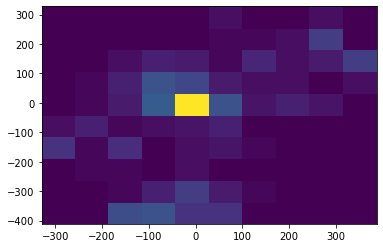

pandas.core.frame.DataFrame

In [24]:
plot_find_wound_location(trajectory)


In [19]:
# Plot of temporal bins of the trajectory data 
def plotxy_time_bins(dataframe):
    trajectory = dataframe
    t20 = trajectory[(trajectory['t'] >= 0) & (trajectory['t'] <= (20 * 60))]
    t35 = trajectory[(trajectory['t'] >= (20 * 60)) & (trajectory['t'] <= (35 * 60))]
    t50 = trajectory[(trajectory['t'] >= (35 * 60)) & (trajectory['t'] <= (50 * 60))]
    t65 = trajectory[(trajectory['t'] >= (50 * 60)) & (trajectory['t'] <= (65 * 60))]
    t90 = trajectory[(trajectory['t']>= (65 * 60)) & (trajectory['t'] <= (90 * 60))]
    t125 = trajectory[(trajectory['t']>= (90 * 60)) & (trajectory['t'] <= (125 * 60))]

    fig, ax = plt.subplots(1,1,figsize=(5,5),sharex=True)

    for ID, tracks in t125.groupby('Track_ID'):
            t125, =plt.plot(tracks['x'], tracks['y'],color = 'xkcd:rust',lw=1)
    for ID, tracks in t90.groupby('Track_ID'):
            t90, =plt.plot(tracks['x'], tracks['y'],color = 'xkcd:pine green',lw=1)
    for ID, tracks in t65.groupby('Track_ID'):
            t65, =plt.plot(tracks['x'], tracks['y'],color = 'xkcd:salmon',lw=1)
    for ID, tracks in t50.groupby('Track_ID'):
            t50, =plt.plot(tracks['x'], tracks['y'],color = 'xkcd:sky blue',lw=1)
    for ID, tracks in t35.groupby('Track_ID'):
            t35, = plt.plot(tracks['x'], tracks['y'],color = 'xkcd:sage',lw=1)
    for ID, tracks in t20.groupby('Track_ID'):
            t20, = plt.plot(tracks['x'], tracks['y'],color = 'xkcd:cobalt',lw=1)
    plt.legend(handles = [t125,t90,t65,t50,t35,t20], 
               labels = ["90 - 125 mins","65 - 90 mins",
               "50 - 65 mins","35 - 50 mins",
               "20 - 35 mins ","0 - 20 mins"],title = "Time Bins", loc = [1,0.5])
    plt.xlabel("X-distance ($\\mu m$")
    plt.ylabel("Y-distance ($\\mu m$)")
    plt.title("Time binning for immune cell trajectories")
    plt.figure(figsize=(8, 6), dpi=80)
    plt.tight_layout()

In [20]:
# Here we plot the spatial bins of the trajectory data 
def plotxy_space_bins(dataframe): 
    trajectory = dataframe
    s25 = trajectory[(trajectory['r'] >= 0)  & (trajectory['r'] <= 70)]
    s50 = trajectory[(trajectory['r'] >= 70)  & (trajectory['r'] <= 140)]
    s75 = trajectory[(trajectory['r'] >= 140)  & (trajectory['r'] <= 250)]
    s100 = trajectory[(trajectory['r'] >= 250)  & (trajectory['r'] <= 360)]
    s125 = trajectory[(trajectory['r'] >= 360)  & (trajectory['r'] <= 500)]

    fig, ax = plt.subplots(1,1,figsize=(5,5),sharex=True)

    for ID, tracks in s125.groupby('Track_ID'):
            s125, =plt.plot(tracks['x'], tracks['y'],color = 'xkcd:rust',lw=1)
    for ID, tracks in s100.groupby('Track_ID'):
            s100, =plt.plot(tracks['x'], tracks['y'],color = 'xkcd:pine green',lw=1)
    for ID, tracks in s75.groupby('Track_ID'):
            s75, =plt.plot(tracks['x'], tracks['y'],color = 'xkcd:salmon',lw=1)
    for ID, tracks in s50.groupby('Track_ID'):
            s50, =plt.plot(tracks['x'], tracks['y'],color = 'xkcd:sky blue',lw=1)
    for ID, tracks in s25.groupby('Track_ID'):
            s25, = plt.plot(tracks['x'], tracks['y'],color = 'xkcd:sage',lw=1)
    plt.legend(handles = [s125,s100,s75,s50,s25], 
               labels = ["360 - 500$\\mu m$","250 - 360$\\mu m$",
               "140 - 250$\\mu m$","70 - 140$\\mu m$",
               "0 - 70$\\mu m$"],title = "Spatial Bins", loc = [1,0.5])
    plt.xlabel("X-distance ($\\mu m$)")
    plt.ylabel("Y-distance ($\\mu m$)")
    plt.title("Spatial binning for immune cell trajectories")
    plt.tight_layout()

## Random walk inference 

These two functions (space_slice and time_slice), slice the dataframe into temporal and spatial binning for processing. Here we use the time and space bins which are defined in the Weavers et al paper. We create a list of lists which is split into the time and space bins, and then run through the random walk inference

N.B. I've ignored the last two time bins due to the fact that there wasn't enough tracks populating them to run the inference on 

In [23]:
def spatial_temporal_binning(dataframe):
    def space_binning(trajectory):
        s70 = trajectory[(trajectory['r'] >= 0) & (trajectory['r'] <= 70)]
        s140 = trajectory[(trajectory['r'] >= 70) & (trajectory['r'] <= 140)]
        s250 = trajectory[(trajectory['r'] >= 140) & (trajectory['r'] <= 250)]
        s360 = trajectory[(trajectory['r'] >= 250) & (trajectory['r'] <= 360)]
        s500 = trajectory[(trajectory['r'] >= 360) & (trajectory['r'] <= 500)]
        return [s70, s140, s250, s360, s500]


    def time_binning(space_bin):
        t20 = space[(space['t'] >= 0) & (space['t'] <= (20 * 60))]
        t35 = space[(space['t'] >= (20 * 60)) & (space['t'] <= (35 * 60))]
        t50 = space[(space['t'] >= (35 * 60)) & (space['t'] <= (50 * 60))]
        t65 = space[(space['t'] >= (50 * 60)) & (space['t'] <= (65 * 60))]
        t90 = space[(space['t'] >= (65 * 60)) & (space['t'] <= (90 * 60))]
        t125 = space[(space['t'] >= (90 * 60)) & (space['t'] <= (125 * 60))]

        return [t20, t35, t50, t65, t90, t125]


    distance = space_binning(trajectory)
    time_space_bins = list(map(time_binning,distance))
    
    return time_space_bins





NameError: name 'space' is not defined

In [21]:
time_space_bins = list(map(time_slice,distance))


source = PointSource(position=np.array([0, 0])) # Source is a position at 0,0 due to readjustment of tracks earlier
NWalkers = 40 # 100 walkers and 1000 iterations seem to give the best convergence of the emcee 
NIters = 1000
t = 0
total_bins = (len(distance) * len(s_distance[0])) # total number of bins to run the inference on 
for i in range(len(distance)):
    for j in range(len(s_distance[0])):
        t += 1  # Tracks the number of bins
        print('analysing bin {}/{}'.format(t,total_bins))  # to give an overall sense of progress
        inferer = BiasedPersistentInferer(
            prepare_paths([paths[['x', 'y']].values for id, paths in s_distance[i][j].groupby('Track_ID')],
                          include_t=False), source) # prepares the data for running the inference 
        inf_out = inferer.ensembleinfer(NWalkers, NIters) # calls the emcee inferer 
        np.save(
            '../data/WalkerData/WeaversData/WeaversL1{}{}'.format(
                i, j), inf_out) # Saves to local data file 

  1%|          | 7/1000 [00:00<00:15, 62.45it/s]

analysing bin 1/20
Running sampler: 


100%|██████████| 1000/1000 [00:12<00:00, 82.82it/s]
/Users/danieltudor/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
  1%|          | 7/1000 [00:00<00:15, 63.08it/s]

analysing bin 2/20
Running sampler: 


  1%|          | 6/1000 [00:00<00:17, 58.15it/s]

analysing bin 3/20
Running sampler: 


  1%|          | 7/1000 [00:00<00:15, 64.42it/s]

analysing bin 4/20
Running sampler: 


  1%|          | 9/1000 [00:00<00:11, 83.43it/s]

analysing bin 5/20
Running sampler: 


  1%|          | 10/1000 [00:00<00:10, 91.35it/s]

analysing bin 6/20
Running sampler: 


  2%|▏         | 19/1000 [00:00<00:10, 90.12it/s]/Users/danieltudor/Documents/Wood group/ImmuneCellMigrationAnalysis/inference/walker_inference.py:226: RuntimeWarning: divide by zero encountered in log
  log_p_0 = np.log(p_0)
  1%|          | 9/1000 [00:00<00:12, 81.59it/s]

analysing bin 7/20
Running sampler: 


  1%|▏         | 13/1000 [00:00<00:07, 128.06it/s]

analysing bin 8/20
Running sampler: 


  1%|          | 6/1000 [00:00<00:17, 58.16it/s]

analysing bin 9/20
Running sampler: 


  1%|          | 8/1000 [00:00<00:13, 71.11it/s]

analysing bin 10/20
Running sampler: 


  1%|          | 10/1000 [00:00<00:10, 97.19it/s]

analysing bin 11/20
Running sampler: 


  1%|          | 12/1000 [00:00<00:08, 114.08it/s]

analysing bin 12/20
Running sampler: 


  1%|          | 8/1000 [00:00<00:13, 74.13it/s]

analysing bin 13/20
Running sampler: 


  1%|          | 7/1000 [00:00<00:14, 66.65it/s]

analysing bin 14/20
Running sampler: 


  1%|          | 7/1000 [00:00<00:14, 67.28it/s]

analysing bin 15/20
Running sampler: 


  1%|          | 8/1000 [00:00<00:13, 71.95it/s]

analysing bin 16/20
Running sampler: 


  1%|          | 10/1000 [00:00<00:10, 95.55it/s]

analysing bin 17/20
Running sampler: 


  1%|          | 8/1000 [00:00<00:12, 78.22it/s]

analysing bin 18/20
Running sampler: 


  1%|          | 11/1000 [00:00<00:09, 108.07it/s]

analysing bin 19/20
Running sampler: 


  1%|          | 11/1000 [00:00<00:09, 102.03it/s]

analysing bin 20/20
Running sampler: 


100%|██████████| 1000/1000 [00:05<00:00, 168.71it/s]


## Random walk plotting 

This plots the bias, persistence and weighting parameters. The function loadData calls the saved inference numpy array for each time-space bin and removes the burn-in (here called discard). 

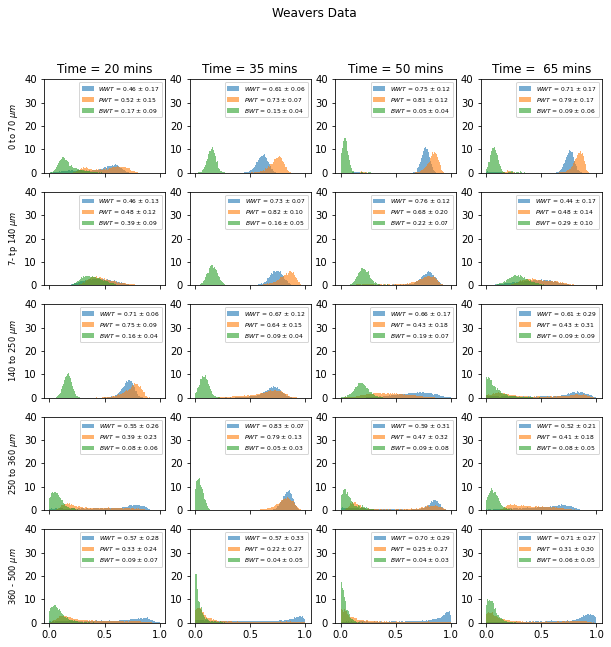

In [11]:
Space = ["0 to 70 $\mu m$","7- tp 140 $\mu m$","140 to 250 $\mu m$","250 to 360 $\mu m$","360 - 500 $\mu m$"]
Time = ["Time = 20 mins","Time = 35 mins","Time = 50 mins","Time =  65 mins"]



def loadData(i, j):
    WT = np.load('../data/WalkerData/WeaversData/WeaversL1{}{}.npy'.format(i,j), allow_pickle=True)
    samplerWT = WT[0]
    WildTypeChain = samplerWT.get_chain(discard=250,thin = 2,flat=True)
    return WildTypeChain


fig, ax = plt.subplots(5, 4, figsize=(10, 10), sharex=True)
fig.suptitle("Weavers Data")
for i in range(5):
    for j in range(4):
        data = loadData(i,j)
        WWT = data[:,0]
        PWT = data[:,1]
        BWT = data[:,2]
        ax[i,j].set_ylim([0, 40])
        ax[i,j].hist(WWT,label='$WWT$ = {:.2f} $\pm$ {:.2f}'.format(np.mean(WWT), np.std(WWT)),bins=100,alpha=0.6,density=True)
        ax[i,j].hist(PWT,label='$PWT$ = {:.2f} $\pm$ {:.2f}'.format(np.mean(PWT), np.std(PWT)),bins=100,alpha=0.6,density=True)
        ax[i,j].hist(BWT,label='$BWT$ = {:.2f} $\pm$ {:.2f}'.format(np.mean(BWT), np.std(BWT)),bins=100,alpha=0.6,density=True)

        ax[0,j].set_title(Time[j])
        ax[i,0].set_ylabel(Space[i], rotation=90, size='small')
        ax[i,j].legend(prop={'size': 6})
plt.savefig('../Images/PosterImages/WalkerPoster/Weavers_loc1.pdf')

Here we use the functions bias and ob_bias to extract our bias and weight each time bin and then calculate the mean and standard deviations.

In [12]:
def Bias(i,j):
    DataFile1 = loadData(i,j)
    W1 =  DataFile1[:,0]
    B1 =  DataFile1[:,2]
    OBWT1 = (W1 * B1)
    return OBWT1

def OB_bias(val):
    OBWT1 = []
    for i in range(5):
            WT1 =  Bias(i,val)
            OBWT1.append(WT1)
    means = []
    std = []
    for i in range(5):
        means.append(np.mean(OBWT1[i]))
        std.append(np.std(OBWT1[i]))
    return means,std

Text(0.5, 23.999999999999957, 'Distance $\\mu$m')

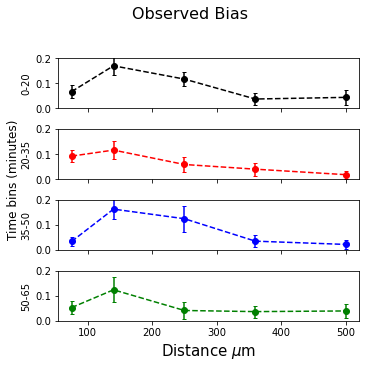

In [13]:
fig, ax = plt.subplots(4,1,figsize=(5,5),sharex=True)
colors = ['k', 'r','b','g']
Time = ["0-20","20-35","35-50","50-65"]
fig.suptitle("Observed Bias",fontsize=16)

for i in range(4):
    OB = OB_bias(i)
    Mean = OB[0]
    Std = OB[1]
    x = [75,140,250,360,500]
    ax[i].errorbar(x,Mean,yerr = Std,fmt='o--',capsize=2,color = colors[i])
    ax[i].set_ylabel(Time[i], rotation=90, fontsize = 10)
    ax[i].set_ylim(0,0.2)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.text(0.01,0.5, "Time bins (minutes)", ha="center", va="center", fontsize=12,rotation=90)
plt.xlabel("Distance $\mu$m", fontsize=15)



## Attractant inference 

The bias_values calculates the observed bias mean and standard deviation for each time and space bin. This is called within the for loop which populates a dictionary for each time-space bin. The attractant inferer is then called and the final inference numpy array is saved to local data file. 

In [9]:
n_walkers = 50
n_iter = 5000


distance = [35, 105, 195, 305]
time = [10, 28, 43, 58, 110]
ob_readings = {}

# This function reads in previously run data from walker inference pipeline, and outputs the observed bias mean and std\
# for the dataframe. The inputs are x,y which correspond to the file formats


def bias_values(i, j): # Change to loading bias values
    input_data = np.load('../data/WalkerData/WeaversData/WeaversL1{}{}.npy'.format(i,j), allow_pickle=True)
    sampler = input_data[0]  # Extracts the posterior chain array from the input_data array
    # Removes the burn-in, thins the posterior data and flattens the walkers into a single array
    input_data = sampler.get_chain(discard=250, thin=2, flat=True)
    w = input_data[:, 0]  # The weighting parameter from the walker posterior array
    b = input_data[:, 2]  # The bias parameter from the walker posterior array
    obwt = (w * b)  # The observed bias parameter from the walker posterior array
    mean = np.mean(obwt)
    std = np.std(obwt)
    return mean, std

"""
Here we define a nested for loop which populates the dictionary ob_readings with the mean and std of the current 
observed bias. This is then ready to be read into our attractant inference as the data for the inference pipeline. 
"""
for i in range(len(time)):
    for j in range(len(distance)):
        ObBias = bias_values(j, i)
        ob_mean = ObBias[0]
        ob_std = ObBias[1]
        ob_readings[(distance[j], time[i])] = (ob_mean, ob_std)
#Use enumerate, zip, dict comp 

# Sets the wound location
wound = PointWound(position=np.array([0, 0]))
inferer = AttractantInferer(ob_readings, wound=wound, t_units='minutes', dynamics = 0)
# Emcee (Ensemble Monte Carlo)
Ensemble_out = inferer.ensembleinfer(n_walkers, n_iter)
# This saves the Emcee output to the data folder
Post_Save_Emcee = np.save('../data/WalkerData/Weavers_data', Ensemble_out)


  0%|          | 2/5000 [00:00<04:24, 18.88it/s]

Running sampler: 


100%|██████████| 5000/5000 [03:14<00:00, 25.73it/s]
/Users/danieltudor/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


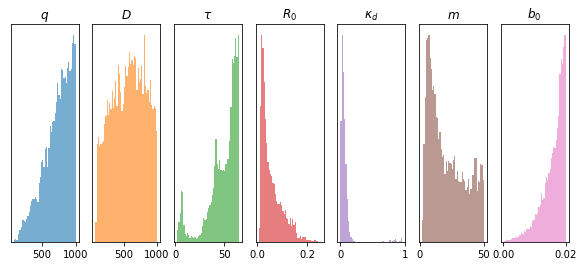

In [12]:
# Plotting of inferred attractant parameters 


sampler =Ensemble_out[0]
Att_out = sampler.get_chain(discard=2500,thin = 1,flat=True)
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(10, 4), sharex='col')
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
names = ['$q$', '$D$', '$\\tau$','$R_0$', '$\kappa_d$', '$m$', '$b_0$']

for j in range(7):
        axes[j].set_title("{}".format(names[j]))
        axes[j].set_yticks([])
        axes[j].hist(Att_out[:, j], bins=50, color=cols[j], alpha=0.6, density=True)



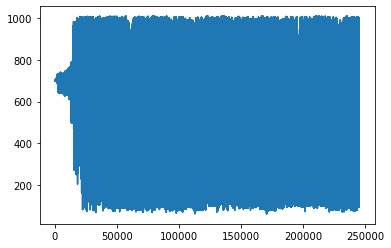

In [11]:
plt.plot(Att_out[:,1])